## Imports

In [116]:
import logging
import os
import random
import sys
from collections import deque
from operator import itemgetter

import gym_donkeycar
import gymnasium as gym
import imageio
import ipywidgets as widgets
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import display
from ipywidgets import HBox, VBox
from matplotlib import pyplot as plt
from PIL import Image
from ruamel.yaml import YAML
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from tensorboard import notebook
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from torch import distributions as dist
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

import gym.spaces as gym_spaces
import gymnasium as gym  # overwrite OpenAI gym

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium.spaces.box") # module="gymnasium"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

import stable_baselines3 as sb3
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from src.actor_critic_dreamer import ActorCriticDreamer
from src.actor_critic import ContinuousActorCritic
from src.blocks import CategoricalStraightThrough, ConvBlock
from src.categorical_vae import CategoricalVAE
from src.imagination_env import make_imagination_env
from src.mlp import MLP
from src.preprocessing import transform
from src.replay_buffer import ReplayBuffer
from src.rssm import RSSM
from src.utils import (load_config, make_env, save_image_and_reconstruction,
                       to_np, symlog, symexp)
from src.vae import VAE

torch.cuda.empty_cache()
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load the config
config = load_config()
for key in config:
    locals()[key] = config[key]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the environment

In [6]:
# env = make_env()

In [8]:
env = gym.make("Pendulum-v1")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=config["n_updates"])
env = gym.wrappers.TimeLimit(env, max_episode_steps=config["max_episode_steps"])
env = gym.wrappers.AutoResetWrapper(env)
env = gym.experimental.wrappers.RescaleActionV0(env, min_action=config["action_space_low"], max_action=config["action_space_high"])

In [186]:
agent = ContinuousActorCritic()
ac = ActorCriticDreamer()
# agent.load_weights("weights/ContinuousActorCritic_0")

# vae = VAE()
# vae.optim = optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-6)

In [19]:
torch.sum(ac.critic(obs))

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [11]:
# batch_rewards, batch_log_probs, batch_value_preds, last_value_pred, batch_entropies, batch_masks
batch_rewards

tensor([-9.6681, -9.3535, -9.0774, -8.8249, -8.7142, -8.7512, -8.8886, -9.0520,
        -9.3376, -9.5685, -9.9011, -9.7058, -9.3661, -9.0949, -8.8370, -8.5613],
       device='cuda:0', dtype=torch.float64)

In [12]:
batch_masks.shape

torch.Size([16])

In [ ]:
# append the last value pred to the value preds tensor
ep_value_preds = torch.cat((ep_value_preds, last_value_pred.unsqueeze(1).detach()), dim=0)

# set up tensors for the advantage calculation
returns = torch.zeros_like(ep_rewards).to(self.device)
# advantages = torch.zeros_like(ep_rewards).to(self.device)
# next_advantage = torch.zeros_like(last_value_pred)

for t in reversed(range(len(ep_rewards))):
    returns[t] = ep_rewards[t] + self.gamma * ep_masks[t] * ((1-self.lam) * ep_value_preds[t+1] + self.lam * returns[t+1])

In [18]:
ac.get_loss(batch_rewards, batch_log_probs, batch_value_preds, last_value_pred, batch_entropies, batch_masks)

17
16
tensor([[-114.3007],
        [-109.7344],
        [-105.2457],
        [-100.7979],
        [ -96.3684],
        [ -91.8087],
        [ -86.9555],
        [ -81.6863],
        [ -75.9505],
        [ -69.5931],
        [ -62.6372],
        [ -54.9422],
        [ -47.0237],
        [ -39.0220],
        [ -30.8603],
        [ -22.5155],
        [ -13.9961]], device='cuda:0', grad_fn=<CopySlices>)
tensor([[-4.7475],
        [-4.7071],
        [-4.6658],
        [-4.6230],
        [-4.5785],
        [-4.5305],
        [-4.4768],
        [-4.4151],
        [-4.3432],
        [-4.2569],
        [-4.1532],
        [-4.0243],
        [-3.8717],
        [-3.6894],
        [-3.4614],
        [-3.1577],
        [-2.7078]], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17, 1])
value_preds: torch.Size([17, 1])


(tensor(97.4321, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(-1.8619, device='cuda:0', grad_fn=<SubBackward0>))

In [301]:
def twohot_encode(x):
    """
    x: the original return
    Returns the twohot encoded symlog return as a (255,) vector.
    """
    # buckets = torch.linspace(config["min_bucket"], config["max_bucket"], config["num_buckets"]).to(device)
    buckets = torch.linspace(-2, 2, 9).to(device)
    print(buckets)
    encoded = torch.zeros_like(buckets).to(device)
    x = symlog(x)
    if x < buckets[0]:
        encoded[0] = 1.0
    elif x > buckets[-1]:
        encoded[-1] = 1.0
    else:
        # index: right bucket (k+1 in the DreamerV3 paper), index-1: left bucket (k in the DreamerV3 paper)
        index = torch.searchsorted(buckets, x, side="right") # index: buckets[index-1] <= v < buckets[index]
        weight = (buckets[index] - x) / (buckets[index] - buckets[index-1])
        print(weight)
        encoded[index-1] = weight
        encoded[index] = 1 - weight
    return encoded


# Example usage:
test_return = torch.Tensor([0.8]).to(device)
encoded_target = twohot_encode(test_return)
buckets = torch.linspace(-2, 2, 9).to(device)

print("Encoded Target:", encoded_target)
print("Restored Target:", symexp(encoded_target @ buckets))

tensor([-2.0000, -1.5000, -1.0000, -0.5000,  0.0000,  0.5000,  1.0000,  1.5000,
         2.0000], device='cuda:0')
tensor([0.8244], device='cuda:0')
Encoded Target: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8244, 0.1756, 0.0000, 0.0000],
       device='cuda:0')
Restored Target: tensor(0.8000, device='cuda:0')


In [305]:
(1-0.5878)/(1-0.5)

0.8244

In [304]:
symexp(0.8244 * 0.5 + 0.1756 * 1)

0.8000240033362289

In [300]:
symlog(0.8)

0.5877866649021191

In [277]:
symexp(15)

3269016.3724721107

In [ ]:
3,269,016

In [ ]:
485,165,194

In [ ]:
162,000

In [ ]:
485,165,194

In [270]:
symlog()

-19.99999999915536

In [264]:
returns = torch.rand(5).to(device)
encoded_targets = torch.stack([twohot_encode(r) for r in returns])

print(returns)
print(symexp(encoded_targets @ buckets))

tensor([0.0678, 0.7529, 0.1364, 0.2639, 0.4595], device='cuda:0')
tensor([0.0678, 0.7529, 0.1364, 0.2639, 0.4595], device='cuda:0')


In [194]:
def apply_critic(ac, obs):
    """
    obs: an observation
    
    Returns the predicted original return.
    Because the critic is trained to predict symlog returns, the prediction needs to be symexp'd.
    """
    buckets = torch.linspace(config["min_bucket"], config["max_bucket"], config["num_buckets"]).to(device)
    return symexp(ac.critic(obs) @ buckets)

apply_critic(ac, obs)

tensor(-95.2481, device='cuda:0', grad_fn=<MulBackward0>)

In [237]:
losses = []

for i in tqdm(range(3000)):
    obs = torch.rand(3).to(device)
    
    # prediction
    prediction = ac.critic(obs) # (255,)

    # label
    test_return = torch.mean(obs * 100)  # torch.Tensor([-100]).to(device)
    encoded_target = twohot_encode(test_return, buckets).detach() # (255,)

    # update critic
    critic_loss = - encoded_target @ torch.log(prediction)
    ac.critic_optim.zero_grad()
    critic_loss.backward(retain_graph=True)
    nn.utils.clip_grad_norm_(ac.critic.parameters(), max_norm=ac.max_grad_norm, norm_type=2)
    ac.critic_optim.step()
    
    losses.append(to_np(critic_loss))

100%|█████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1082.09it/s]


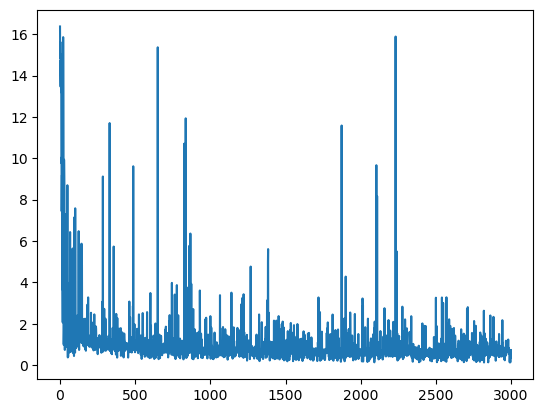

In [238]:
plt.plot(losses)

In [243]:
obs = torch.rand(3).to(device)
print("target:", torch.mean(obs * 100))
print("prediction:", apply_critic(ac, obs))

target: tensor(29.3070, device='cuda:0')
prediction: tensor(28.7844, device='cuda:0', grad_fn=<MulBackward0>)


In [170]:
# manual crossentropy loss for one t: (sum over elements in batch)
# - encoded_target @ torch.log(prediction)

In [267]:
ac.critic(torch.rand(5,3).to(device)).shape

torch.Size([5, 255])

In [10]:
# New training loop with batches

losses = {
    "critic_loss": [],
    "actor_loss": [],
}

# Logging
writer = SummaryWriter(log_dir)
if config["show_inline_tensorboard"]:
    notebook.start(f"--logdir={log_dir}")

for sample_phase in tqdm(range(n_updates)):
    
    batch_observations = []
    
    # NEW
    batch_rewards = []
    batch_log_probs = []
    batch_value_preds = []
    batch_entropies = []
    batch_masks = []
    
    if sample_phase == 0:
        obs, info = env.reset(seed=42)
        obs = torch.Tensor(obs).to(device) ### Pendulum
        # obs = transform(obs)
        # if len(obs.shape) == 4:
        #     obs = obs[0]
        # z, reconstruction, mu, logvar = vae(obs)

    for step in range(n_steps_per_update):
            
        # Add the observation, reconstruction, mu, and logvar to the respective batches
        batch_observations.append(obs)
        value_pred = agent.critic(obs) # obs for Pendulum | z for VAE

        # Get an action and take an environment step
        action, log_prob, actor_entropy = agent.get_action(obs) ### obs for Pendulum | z for VAE
        obs, reward, terminated, truncated, info = env.step(to_np(action))
        
        # Transform the next obs
        obs = torch.Tensor(obs).to(device) ### Pendulum
        # obs = transform(obs)
        # if len(obs.shape) == 4:
        #     obs = obs[0]
        # z, reconstruction, mu, logvar = vae(obs)
        
        # Collect the necessary data for an agent update
        batch_rewards.append(reward)
        batch_log_probs.append(log_prob)
        batch_entropies.append(actor_entropy)
        mask = torch.tensor(0.0 if terminated else 1.0)
        batch_masks.append(mask)
        batch_value_preds.append(value_pred)

    # Convert the batch tensors to tensors
    batch_observations = torch.stack(batch_observations).to(device)  # [n_steps_per_update, *obs_shape]
    batch_rewards = torch.tensor(batch_rewards).to(device)  # [n_steps_per_update]
    batch_log_probs = torch.stack(batch_log_probs).to(device)  # [n_steps_per_update]
    batch_value_preds = torch.stack(batch_value_preds).to(device)  # [n_steps_per_update]
    last_value_pred = agent.critic(obs).to(device)  # last value prediction for GAE
    batch_entropies = torch.stack(batch_entropies).to(device)  # [n_steps_per_update]
    batch_masks = torch.stack(batch_masks).to(device)  # [n_steps_per_update]

    # Update the agent's parameters
    critic_loss, actor_loss = agent.get_loss(
        batch_rewards, batch_log_probs, batch_value_preds, last_value_pred, batch_entropies, batch_masks
    )
    agent.update_parameters(critic_loss, actor_loss)
    
    # Update the VAE's parameters
    # vae_loss, reconstruction_loss, kld_loss = vae.get_loss(batch_, x_hat, mu, logvar)
    # vae.optim.zero_grad()
    # vae_loss.backward()
    # vae.optim.step()    

    if sample_phase % config["log_interval"] == 0:
        
        # Log the losses
        losses["critic_loss"].append(to_np(critic_loss))
        losses["actor_loss"].append(to_np(actor_loss))

        # Log the episode metrics
        if len(env.return_queue):
            writer.add_scalar("episode_return", np.array(env.return_queue)[-1:], global_step=len(env.return_queue))
        writer.add_scalar("critic_loss", to_np(critic_loss), global_step=sample_phase)
        writer.add_scalar("actor_loss", to_np(actor_loss), global_step=sample_phase)


  0%|▎                                                                                      | 128/31250 [00:02<11:38, 44.56it/s]


KeyboardInterrupt: 

In [ ]:
# TODO: VAE add loss, update

In [ ]:
e

In [79]:
env = gym.make("Pendulum-v1", render_mode="human")

obs, info = env.reset()

for i in range(1000):
    action, _, _ = agent.get_action(obs)
    obs, _, _, _, _ = env.step(to_np(action))

In [ ]:
# vae.save_weights()

In [ ]:
agent.actor(z)

In [ ]:
mu, var = agent.actor(z)

In [ ]:
action_pd = dist.MultivariateNormal(mu, var * torch.eye(mu.shape[0], device=agent.device))
action = action_pd.sample()
action

In [ ]:
action_pd.log_prob(action)

In [ ]:
future_return = 0.0
returns = []

for r in reversed(batch_rewards):
    future_return = r + config["gamma"] * future_return
    returns.insert(0, future_return)

In [ ]:
returns = torch.tensor(returns)
returns = (returns - returns.mean()) / (returns.std() + 1e-8)

In [ ]:
returns

In [ ]:
log_prob

In [ ]:
    losses["vae_loss"].append(to_np(vae_loss))
    losses["reconstruction_loss"].append(to_np(reconstruction_loss))
    losses["KLD_loss"].append(to_np(KLD_loss))
    losses["critic_loss"].append(to_np(critic_loss))
    losses["actor_loss"].append(to_np(actor_loss))


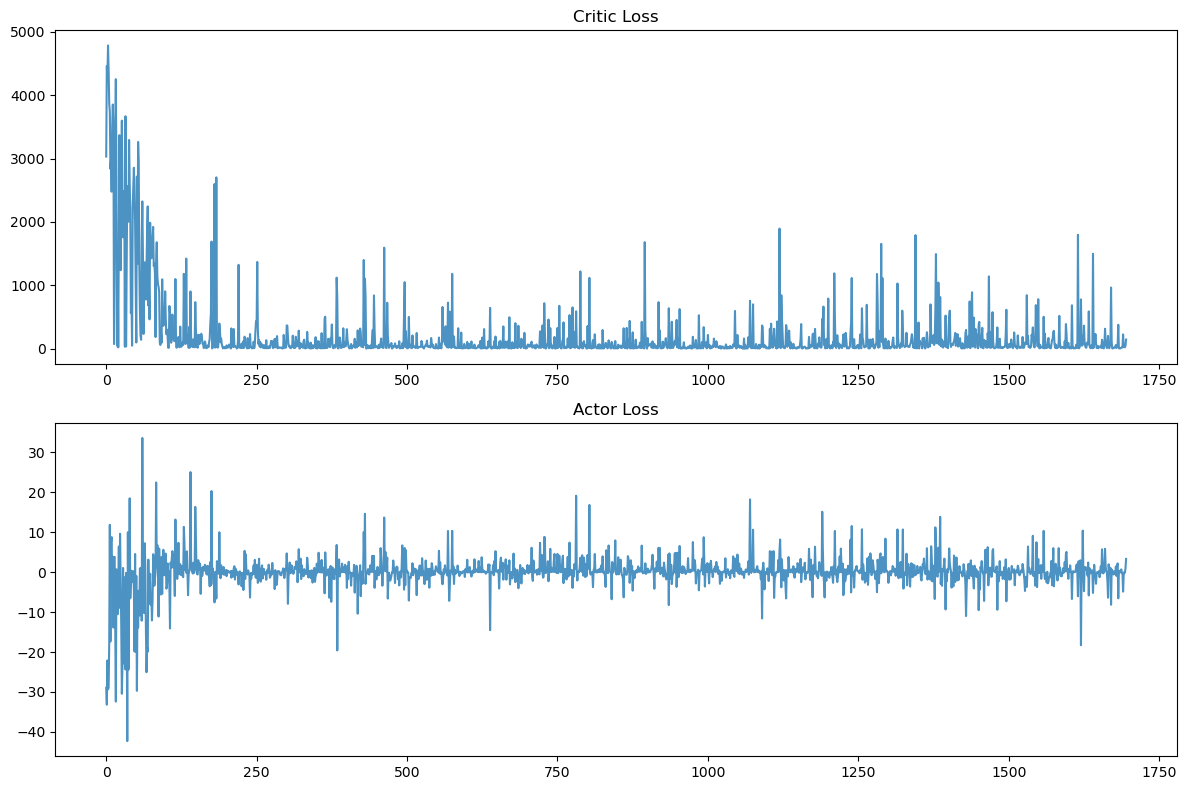

In [67]:
import matplotlib.pyplot as plt

# Assuming `losses` is a dictionary containing the loss values

# Create a figure and subplots
fig, axs = plt.subplots(2, figsize=(12, 8))

# Plot VAE loss

# Plot Critic loss
axs[0].plot(losses["critic_loss"], alpha=0.8)
axs[0].set_title("Critic Loss")

# Plot Actor loss
axs[1].plot(losses["actor_loss"], alpha=0.8)
axs[1].set_title("Actor Loss")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
batch_observations.shape

In [ ]:
batch_reconstructions.shape

In [ ]:
batch_mu.shape

In [ ]:
batch_logvar.shape

In [ ]:
batch_rewards.shape

In [ ]:
batch_log_probs.shape

In [ ]:
batch_value_preds.shape

In [ ]:
last_value_pred.shape

In [ ]:
batch_entropies.shape

In [ ]:
batch_masks.shape

In [ ]:
# max_episode_steps, 

In [ ]:
plt.plot(losses["vae_loss"])

In [ ]:
plt.plot(losses["reconstruction_loss"])

In [ ]:
plt.plot(losses["KLD_loss"])

In [ ]:
obs, info = env.reset(seed=42)

if len(obs.shape) == 4:
    obs = obs[0]

obs = transform(obs)

plt.imshow(to_np(torch.permute(obs, (1,2,0))))

In [ ]:
reconstruction, mu, logvar = vae(torch.randn(obs.shape).to(device))
plt.imshow(to_np(torch.permute(reconstruction, (1,2,0))))